In [43]:
%matplotlib inline
import sys
sys.path.insert(1, '../../src/')

In [44]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msno

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [45]:
import cleaning_class as cl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
df = pd.read_csv('../../data/training.csv') 

In [47]:
cl.cleaning(df)

In [48]:
df.columns

Index(['IsBadBuy', 'Auction', 'VehicleAge', 'Transmission', 'WheelTypeID',
       'VehOdo', 'Nationality', 'Size', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VNST', 'VehBCost', 'WarrantyCost'],
      dtype='object')

### Label Encoder

In [49]:
df = pd.get_dummies(df)
df = pd.get_dummies(df, columns=['WheelTypeID'])
df.columns

Index(['IsBadBuy', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost',
       'Auction_ADESA', 'Auction_MANHEIM', 'Auction_OTHER',
       'Transmission_AUTO', 'Transmission_MANUAL', 'Nationality_AMERICAN',
       'Nationality_OTHER', 'Nationality_OTHER ASIAN',
       'Nationality_TOP LINE ASIAN', 'Size_COMPACT', 'Size_CROSSOVER',
       'Size_LARGE', 'Size_LARGE SUV', 'Size_LARGE TRUCK', 'Size_MEDIUM',
       'Size_MEDIUM SUV', 'Size_SMALL SUV', 'Size_SMALL TRUCK',
       'Size_SPECIALTY', 'Size_SPORTS', 'Size_VAN', 'VNST_AL', 'VNST_AR',
       'VNST_AZ', 'VNST_CA', 'VNST_CO', 'VNST_FL', 'VNST_GA', 'VNST_IA',
       'VNST_ID', 'VNST_IL', 'VNST_IN', 'VNST_KY', 'VNST_LA', 'VNST_MA',
       'VNST_MD

### Train/Test partitioning

In [15]:
from sklearn.model_selection import train_test_split

In [69]:
attributes = [col for col in df.columns if col != 'IsBadBuy']
X = df[attributes].values
y = df['IsBadBuy']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

### Parameter Tuning

In [52]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [58]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("")
            print("Mean validation score Test: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
param_list = {'criterion': ['gini', 'entropy'],
              'max_depth': [None] + list(np.arange(2, 6)),
              'min_samples_split': list(np.arange(2, 50)),
              'min_samples_leaf': list(np.arange(2, 50)),
             }
skf = StratifiedKFold(n_splits=5)
clf = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=200, cv = skf, scoring='f1', n_jobs = 4)
random_search.fit(X, y)
report(random_search.cv_results_, n_top=5)

In [67]:
random_search.best_score_

0.6739619934172195

In [68]:
random_search.best_params_

{'min_samples_split': 35,
 'min_samples_leaf': 6,
 'max_depth': 8,
 'criterion': 'gini'}

### Perform Clustering

In [70]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=35, min_samples_leaf=6)
clf = clf.fit(X_train, y_train)

In [71]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

### Analyze the classification results

Features Importance

In [ ]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

Visualize the decision tree

In [76]:
import pydotplus
from sklearn import tree
from IPython.display import Image

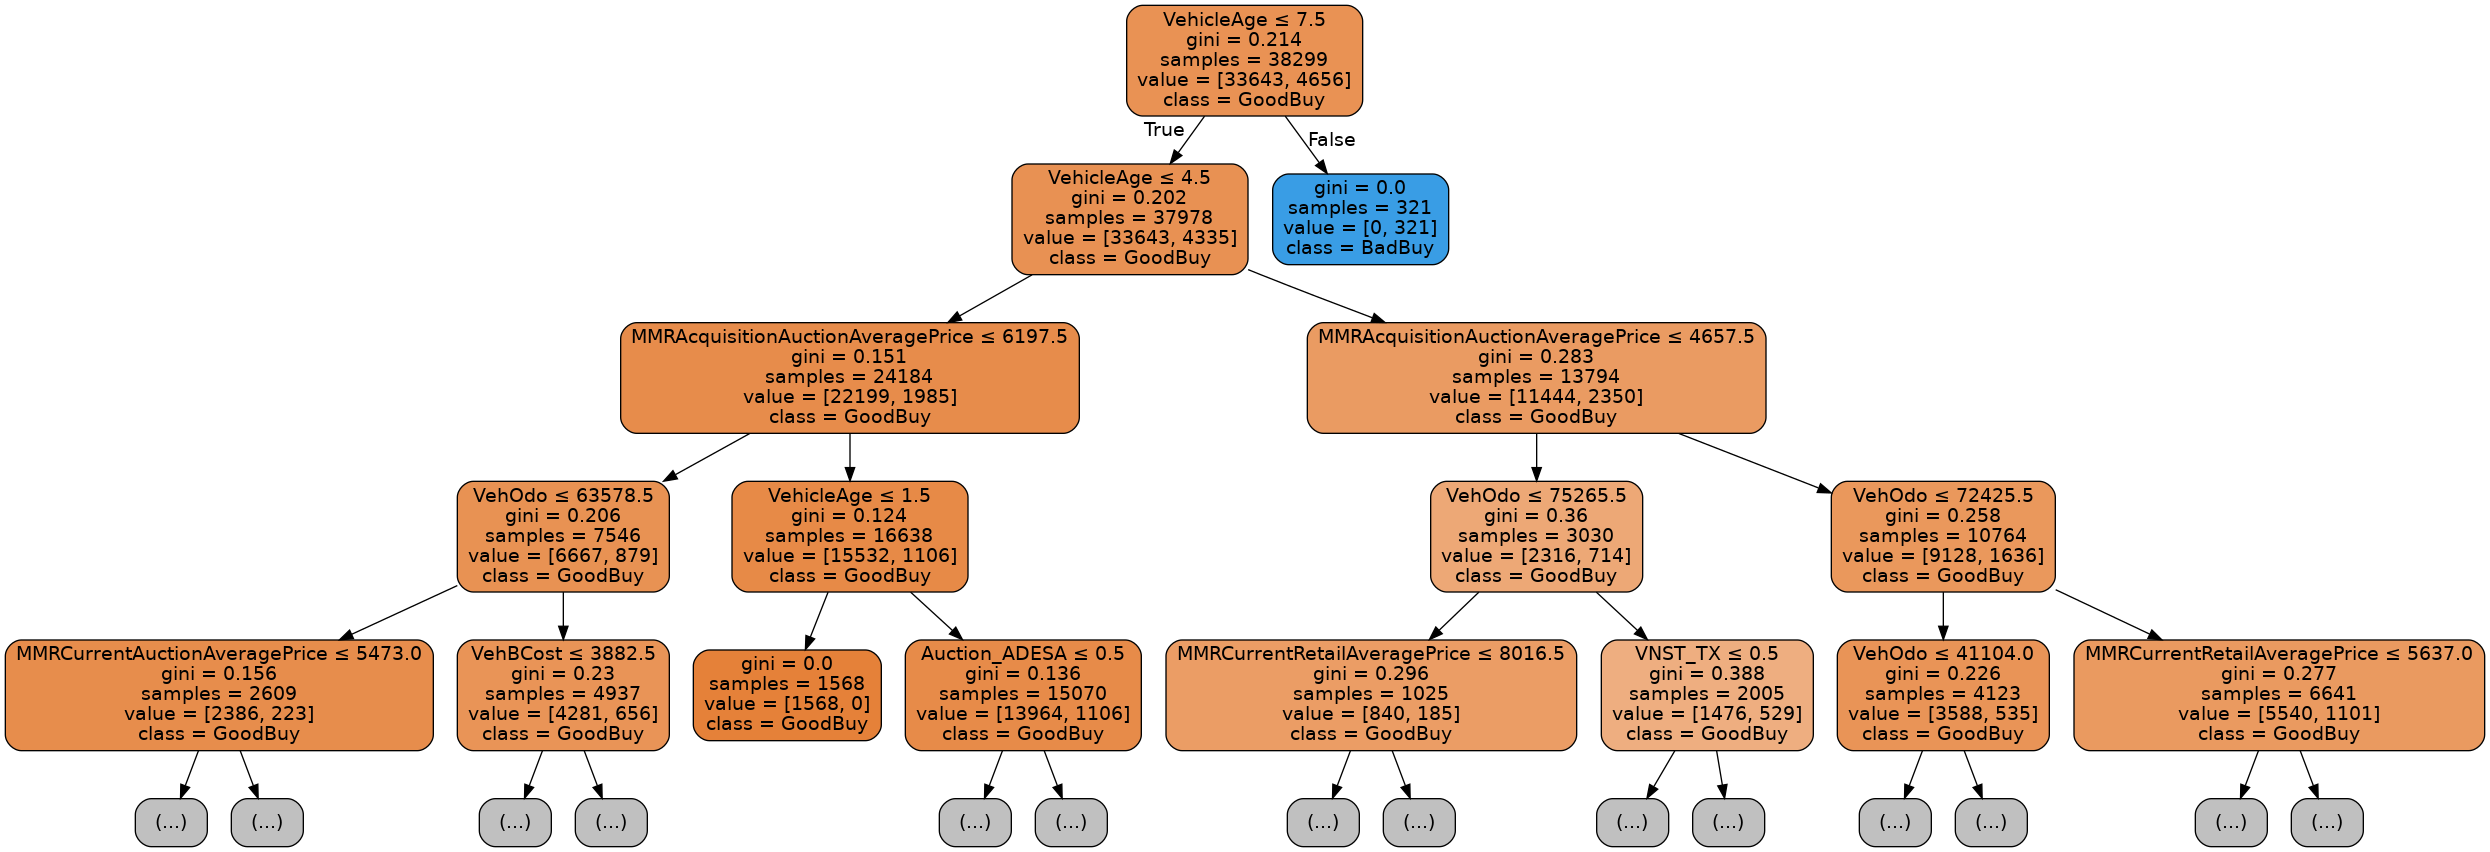

In [78]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=attributes,
                                class_names=['BadBuy' if x == 1 else 'GoodBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Analyze the classification performance

In [72]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

Evaluate the performance

In [73]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

Train Accuracy 0.8884827280085642
Train F1-score [0.94015944 0.18258373]

Test Accuracy 0.8844888509808699
Test F1-score [0.93796623 0.16254417]
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     14419
           1       0.68      0.09      0.16      1995

    accuracy                           0.88     16414
   macro avg       0.79      0.54      0.55     16414
weighted avg       0.86      0.88      0.84     16414



array([[14334,    85],
       [ 1811,   184]])

In [74]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)

0.5431677883939336


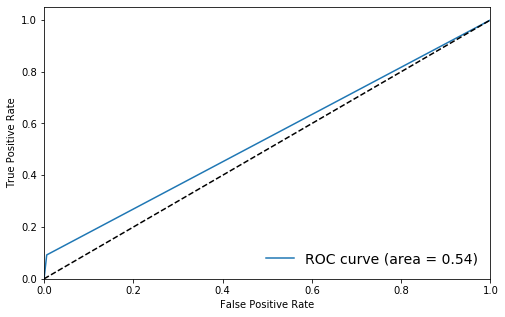

In [75]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate') 
plt.tick_params(axis='both', which='major')
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

Cross Validation

In [40]:
from sklearn.model_selection import cross_val_score

In [41]:
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8867 (+/- 0.00)
F1-score: 0.5484 (+/- 0.02)


### Can we improve the performance using another classifier?

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [181]:
param_list = {'max_depth': [None] + list(np.arange(2, 50)),
              'min_samples_split': [2, 5, 10, 15, 20, 30, 50, 100, 150],
              'min_samples_leaf': [1, 5, 10, 15, 20, 30, 50, 100, 150],
              'criterion': ['gini', 'entropy'],
             }

clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, 
                             min_samples_split=2, min_samples_leaf=1, class_weight=None)

random_search = RandomizedSearchCV(clf, param_distributions=param_list, n_iter=100)
random_search.fit(X, y)
report(random_search.cv_results_, n_top=3)

C:\Users\Giulia\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


KeyboardInterrupt: 

In [ ]:
clf = random_search.best_estimator_

y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

In [ ]:
print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

roc_auc = roc_auc_score(y_test, y_pred, average=None)
roc_auc

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

In [ ]:
scores = cross_val_score(clf, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))